<a href="https://colab.research.google.com/github/eunzzae/Study_DS/blob/main/09)_%EC%8B%A0%EC%9A%A9%EC%B9%B4%EB%93%9C_%EC%82%AC%EA%B8%B0_%EA%B1%B0%EB%9E%98_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 신용카드 사기 거래 예측
>**목차**

* 문제상황 및 데이터 살펴보기  
* 문제해결 프로세스 정의   
1) 의미있는 변수 선택  
2) 사기 거래 특성 파악  
3) ML 활용 사기 거래 예측

In [1]:
# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# ▶ Google drive mount or 폴더 클릭 후 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

# # ▶ 경로 설정 (※ Colab을 활성화시켰다면 보통 Colab Notebooks 폴더가 자동 생성)
# import os
# os.chdir('/content/drive/MyDrive/Colab Notebooks/part3_lecture_fastcampus/chapter09')
# # '/content/drive/MyDrive/Colab Notebooks/ ← 여기 경로까지는 본인의 경로 입력, part3_lecture_fastcampus/chapter09' ← 변경X
# os.getcwd()

Mounted at /content/drive


## 문제상황 및 데이터 살펴보기  
---
> **시나리오**
```
카드사 A는 최근 비트코인 열풍으로 수수료 거래 금액이 늘어 좋으면서도  한 편으로 골치를 썩고 있다. 비트코인 결제를 신용카드로 결제하여 많은  
수수료를 얻어가고 있지만, 그만큼 사기거래가 발생하고 처리해달라는 고객 Claim이 수도 없이 쏟아지기 때문이다. 이에 카드사는 사기거래로  
예측되는 거래건에 경우 거래를 제한하고자 한다.
```  

>**데이터 살펴보기**
* 거래기준 Spending data  
* 데이터 명세

|account_age_days| transaction_amt| transaction_adj_amt|historic_velocity|ip_address|user_agent|
|:---:|:---:|:---:|:---:|:---:|:---:|
|계좌 생성후 지난일|거래금액|거래 조정 금액|과거 거래금액|IP주소|사용환경|
|email_domain|phone_number|billing_city|billing_postal|billing_state|card_bin|
|email 도메인|전화번호|청구도시|청구우편번호|청구주|카드bin번호(앞6자리)|
|currency|cvv|signature_image|transaction_type|transaction_env|EVENT_TIMESTAMP|applicant_name|
|통화|CVV|서명이미지|거래종류|거래환경|거래일자|
billing_address|merchant_id|locale|tranaction_initiate|days_since_last_logon|inital_amount|
|청구주소|상점ID|지역|거래초기코드|마지막로그인후경과일|초기잔액|
|EVENT_LABEL|
|사기여부|

In [2]:
# Data road
import pandas as pd
bath ='/content/drive/MyDrive/[STUDY] 데이터사이언스/데이터분석/data/chapter09_신용카드 사기 거래 예측/'
df = pd.read_csv(bath + 'chapter09_credit_fraud.csv')
df.head()

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,ip_address,user_agent,email_domain,phone_number,billing_city,billing_postal,...,transaction_env,EVENT_TIMESTAMP,applicant_name,billing_address,merchant_id,locale,tranaction_initiate,days_since_last_logon,inital_amount,EVENT_LABEL
0,3371.0,2167.0,56.0,2572.0,154.68.49.124,Opera/9.81.(Windows NT 10.0; ht-HT) Presto/2.9...,perez-garza.com,878-111-5140,Woodsburgh,96336.0,...,X,2020-12-29 09:05:51,Linda Wright,4684 Sharon Ranch,066-82-8795,niu_NZ,O,59.0,13646.0,legit
1,2714.0,2045.0,48.0,4517.0,39.131.125.85,Opera/9.76.(X11; Linux i686; mi-NZ) Presto/2.9...,mcneil-ortega.com,(002)736-0139,West Kevin,78083.0,...,W,2021-06-22 18:05:06,Terri Rivera,7642 Allison Ramp,669-99-9459,apn_IN,J,0.0,11930.0,legit
2,6987.0,2892.0,61.0,5007.0,166.245.194.83,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.6.20) G...,davis-calderon.com,(983)585-2863x652,Lorichester,83236.0,...,X,2021-05-10 13:48:38,Sarah Gray,4948 Lisa Passage,086-41-1624,dv_MV,T,83.0,7412.0,legit
3,2712.0,3040.0,28.0,6022.0,100.1.217.216,Mozilla/5.0 (Macintosh; Intel Mac OS X 10 9_3 ...,rose-lee.org,+1-678-897-3420x60738,Stephenmouth,78364.0,...,N,2021-03-11 07:36:40,Valerie Jenkins,1616 Little Camp,669-97-4021,byn_ER,M,24.0,4623.0,legit
4,3598.0,2976.0,66.0,2600.0,113.156.65.245,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.5.20) G...,nash.net,(013)204-1766x92641,New Brianmouth,77499.0,...,G,2021-03-27 06:13:35,Amy Coleman,149 Harris Rapid,088-21-6329,the_NP,K,21.0,1905.0,legit


## 문제해결 프로세스 정의
---
>**문제정의**

```
- 사기거래로 인한 고객 Claim 증가, 브랜드 이미지 감소, 고객 탈퇴
```

>**기대효과**

```
- 사기거래 거래 제한으로 고객 Claim 감소, 브랜드 이미지 회복, 고객 방어
```

>**해결방안**

```
- 카드 Spending data 활용 사기거래 예측
- Session 1
  Data 전처리와 의미있는 변수에 대해 고민해보고 탐색
- Session 2
  - Numeric(연속형, 숫자형) 변수와 Categorical(범주형) 변수에 대해 탐색
- Session 3
  - ML 알고리즘을 활용하여 사기거래 예측
```

>**성과측정**

```
- 모델 적용 전/후 사기거래 Calim 감소 건수
```

>**현업적용**

```
- 카드 Spending data 실시간 수집
- 거래 발생 마다 모든 거래 Data 모델 Input 후 사기거래 의심 건수 추출
- 사기 가능성 높은 거래 건수에 대해서 제한조치 실행
```

## Session 1
## 의미있는 변수 선택

### Data 전처리

In [3]:
# Data shape
# 150000 row, 26 col로 구성
print('df', df.shape)

df (150000, 26)


In [4]:
# Data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   account_age_days       149892 non-null  float64
 1   transaction_amt        149870 non-null  float64
 2   transaction_adj_amt    149886 non-null  float64
 3   historic_velocity      149885 non-null  float64
 4   ip_address             149873 non-null  object 
 5   user_agent             149887 non-null  object 
 6   email_domain           149910 non-null  object 
 7   phone_number           149873 non-null  object 
 8   billing_city           149884 non-null  object 
 9   billing_postal         149876 non-null  float64
 10  billing_state          149887 non-null  object 
 11  card_bin               149872 non-null  float64
 12  currency               149892 non-null  object 
 13  cvv                    149877 non-null  object 
 14  signature_image        149895 non-nu

In [5]:
# Null 값 확인
df.isnull().sum()

account_age_days         108
transaction_amt          130
transaction_adj_amt      114
historic_velocity        115
ip_address               127
user_agent               113
email_domain              90
phone_number             127
billing_city             116
billing_postal           124
billing_state            113
card_bin                 128
currency                 108
cvv                      123
signature_image          105
transaction_type         116
transaction_env          123
EVENT_TIMESTAMP          112
applicant_name           143
billing_address          134
merchant_id              107
locale                   134
tranaction_initiate      126
days_since_last_logon    136
inital_amount            128
EVENT_LABEL                0
dtype: int64

In [6]:
# 결측치 행 모두 제거(* 결측치 데이터가 작아서 일괄 drop)
df = df.dropna(axis=0)
df.shape

(147000, 26)

In [7]:
# Outlier 확인
df.describe()

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,billing_postal,card_bin,days_since_last_logon,inital_amount
count,147000.000000,147000.000000,147000.000000,147000.000000,147000.000000,147000.000000,147000.000000,147000.000000
mean,4645.817224,2521.343592,54.208837,4702.388673,50179.458129,41834.312320,49.858524,7996.856367
std,1153.792072,604.680167,10.068128,1188.255402,28389.219411,10082.094148,29.208844,4047.922681
min,1.000000,5.000000,1.000000,50.000000,503.000000,6040.000000,0.000000,1000.000000
25%,3824.000000,2103.000000,48.000000,3872.000000,25298.000000,35386.000000,24.000000,4485.000000
50%,4668.000000,2543.000000,55.000000,4729.000000,50072.000000,42086.000000,50.000000,7999.000000
75%,5476.000000,2951.000000,61.000000,5548.000000,74346.000000,47373.000000,75.000000,11495.000000
max,9119.000000,4999.000000,99.000000,9999.000000,99950.000000,67639.000000,100.000000,15000.000000


In [8]:
print(df['user_agent'].head(1))

0    Opera/9.81.(Windows NT 10.0; ht-HT) Presto/2.9...
Name: user_agent, dtype: object


In [9]:
# user_agent 브라우저 name 선택
df['user_agent'] = df['user_agent'].apply(lambda x : x.split('/')[0])

In [10]:
df.head(3)

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,ip_address,user_agent,email_domain,phone_number,billing_city,billing_postal,...,transaction_env,EVENT_TIMESTAMP,applicant_name,billing_address,merchant_id,locale,tranaction_initiate,days_since_last_logon,inital_amount,EVENT_LABEL
0,3371.0,2167.0,56.0,2572.0,154.68.49.124,Opera,perez-garza.com,878-111-5140,Woodsburgh,96336.0,...,X,2020-12-29 09:05:51,Linda Wright,4684 Sharon Ranch,066-82-8795,niu_NZ,O,59.0,13646.0,legit
1,2714.0,2045.0,48.0,4517.0,39.131.125.85,Opera,mcneil-ortega.com,(002)736-0139,West Kevin,78083.0,...,W,2021-06-22 18:05:06,Terri Rivera,7642 Allison Ramp,669-99-9459,apn_IN,J,0.0,11930.0,legit
2,6987.0,2892.0,61.0,5007.0,166.245.194.83,Mozilla,davis-calderon.com,(983)585-2863x652,Lorichester,83236.0,...,X,2021-05-10 13:48:38,Sarah Gray,4948 Lisa Passage,086-41-1624,dv_MV,T,83.0,7412.0,legit


In [11]:
df['EVENT_LABEL'].value_counts()

EVENT_LABEL
legit    138996
fraud      8004
Name: count, dtype: int64

In [12]:
# 약 5% 사기거래률
(8004 / (138996+8004))*100

5.444897959183673

### 의미있는 변수 선택  
---
* 의미있는 변수란  
  * 해당 변수에 의해서 예측하고자 하는 데이터가 잘 구분되어지는 변수
* Numeric 변수  
  * 연속형 변수는 구간화를 통해 범주형 변수로 변경하고, 잘 구분되어지는지 확인(※ 평균 사기거래률 대비 그룹핑ㄹ한 그룹의 사기거래율이 차이 나는 것)
* Categorical 변수  
  * 각 그룹별 예측하고자 하는 데이터가 잘 나눠지는지 확인 (※ 각 그룹마다 사기거래율의 차이가 나는 것)


In [13]:
# 하나의 Col에 대한 데이터 타입 확인
df['user_agent'].dtypes

dtype('O')

In [14]:
# numeric, categorical value 나누기
numeric_list=[]
categorical_list=[]

for i in df.columns:
    if df[i].dtypes == 'O' :
      categorical_list.append(i)
    else :
      numeric_list.append(i)

print("categorical_list : ", categorical_list)
print("numeric_list :", numeric_list)

categorical_list :  ['ip_address', 'user_agent', 'email_domain', 'phone_number', 'billing_city', 'billing_state', 'currency', 'cvv', 'signature_image', 'transaction_type', 'transaction_env', 'EVENT_TIMESTAMP', 'applicant_name', 'billing_address', 'merchant_id', 'locale', 'tranaction_initiate', 'EVENT_LABEL']
numeric_list : ['account_age_days', 'transaction_amt', 'transaction_adj_amt', 'historic_velocity', 'billing_postal', 'card_bin', 'days_since_last_logon', 'inital_amount']


## Session 2
## 사기 거래 특성 파악


### Numeric 변수
---

In [15]:
print('numeric_list :', numeric_list)

numeric_list : ['account_age_days', 'transaction_amt', 'transaction_adj_amt', 'historic_velocity', 'billing_postal', 'card_bin', 'days_since_last_logon', 'inital_amount']


In [16]:
# numeric_list df만 출력
df[numeric_list]

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,billing_postal,card_bin,days_since_last_logon,inital_amount
0,3371.0,2167.0,56.0,2572.0,96336.0,40771.0,59.0,13646.0
1,2714.0,2045.0,48.0,4517.0,78083.0,24480.0,0.0,11930.0
2,6987.0,2892.0,61.0,5007.0,83236.0,37778.0,83.0,7412.0
3,2712.0,3040.0,28.0,6022.0,78364.0,55790.0,24.0,4623.0
4,3598.0,2976.0,66.0,2600.0,77499.0,37370.0,21.0,1905.0
...,...,...,...,...,...,...,...,...
149995,3986.0,2890.0,57.0,4544.0,34817.0,30017.0,99.0,6681.0
149996,5834.0,1875.0,61.0,4369.0,35879.0,65507.0,85.0,2402.0
149997,4781.0,3371.0,48.0,5135.0,84167.0,47079.0,22.0,4113.0
149998,6085.0,2306.0,59.0,4846.0,80391.0,25891.0,70.0,4531.0


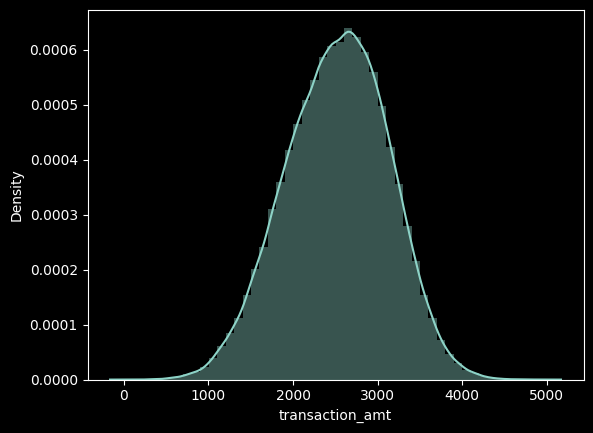

In [17]:
# transaction_amt(거래 금액) 분포 확인
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['dark_background'])

sns.distplot(df['transaction_amt']);

In [18]:
# 구간화
import numpy as np
df['transaction_amt_gp'] = np.where(df['transaction_amt'] <=2000, 1,
                          np.where(df['transaction_amt']<=3000, 2, 3))

df[['transaction_amt','transaction_amt_gp']]

,transaction_amt,transaction_amt_gp
0,2167.0,2
1,2045.0,2
2,2892.0,2
3,3040.0,3
4,2976.0,2
...,...,...
149995,2890.0,2
149996,1875.0,1
149997,3371.0,3
149998,2306.0,2


In [19]:
# 구간화에 따른 사기거래
df.groupby(['transaction_amt_gp', 'EVENT_LABEL'])['transaction_amt'].count()

transaction_amt_gp  EVENT_LABEL
1                   fraud            353
                    legit          29420
2                   fraud           4825
                    legit          79588
3                   fraud           2826
                    legit          29988
Name: transaction_amt, dtype: int64

In [20]:
# 그룹에 따라서 사기거래률이 적절하게 나눠졌다고 볼 수 있음. (평균 사기거래율 5%)
print('gp1 :', (353 / (353+29420)))
print('gp2 :', (4825 / (4825+79588)))
print('gp3 :', (2826 / (2826+29988)))

gp1 : 0.011856379941557787
gp2 : 0.057159442266001684
gp3 : 0.08612177729018101


In [21]:
# DataFrame 형태로 만들기(1단계)
df_tran = pd.DataFrame(df.groupby(['transaction_amt_gp', 'EVENT_LABEL'])['EVENT_TIMESTAMP'].count()).reset_index()
df_tran.head()

,transaction_amt_gp,EVENT_LABEL,EVENT_TIMESTAMP
0,1,fraud,353
1,1,legit,29420
2,2,fraud,4825
3,2,legit,79588
4,3,fraud,2826


In [22]:
# Data Frame 형태로 만들기(2단계)
df_pivot = pd.pivot_table(df_tran, index='transaction_amt_gp', columns='EVENT_LABEL', values='EVENT_TIMESTAMP')

df_pivot = df_pivot.reset_index()
df_pivot.columns.names=['']
df_pivot.head()


,transaction_amt_gp,fraud,legit
0,1,353,29420
1,2,4825,79588
2,3,2826,29988


In [23]:
# Data Frame 형태로 만들기(3단계)
df_pivot['ratio'] = round((df_pivot.iloc[:,1] / (df_pivot.iloc[:, 1] + df_pivot.iloc[:, 2]))*100, 1)
df_pivot.head()

,transaction_amt_gp,fraud,legit,ratio
0,1,353,29420,1.2
1,2,4825,79588,5.7
2,3,2826,29988,8.6


### Categorical 변수
---

In [24]:
df.head(2)

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,ip_address,user_agent,email_domain,phone_number,billing_city,billing_postal,...,EVENT_TIMESTAMP,applicant_name,billing_address,merchant_id,locale,tranaction_initiate,days_since_last_logon,inital_amount,EVENT_LABEL,transaction_amt_gp
0,3371.0,2167.0,56.0,2572.0,154.68.49.124,Opera,perez-garza.com,878-111-5140,Woodsburgh,96336.0,...,2020-12-29 09:05:51,Linda Wright,4684 Sharon Ranch,066-82-8795,niu_NZ,O,59.0,13646.0,legit,2
1,2714.0,2045.0,48.0,4517.0,39.131.125.85,Opera,mcneil-ortega.com,(002)736-0139,West Kevin,78083.0,...,2021-06-22 18:05:06,Terri Rivera,7642 Allison Ramp,669-99-9459,apn_IN,J,0.0,11930.0,legit,2


In [25]:
print('categorical_list :', categorical_list)

categorical_list : ['ip_address', 'user_agent', 'email_domain', 'phone_number', 'billing_city', 'billing_state', 'currency', 'cvv', 'signature_image', 'transaction_type', 'transaction_env', 'EVENT_TIMESTAMP', 'applicant_name', 'billing_address', 'merchant_id', 'locale', 'tranaction_initiate', 'EVENT_LABEL']


In [26]:
df[categorical_list].head()

,ip_address,user_agent,email_domain,phone_number,billing_city,billing_state,currency,cvv,signature_image,transaction_type,transaction_env,EVENT_TIMESTAMP,applicant_name,billing_address,merchant_id,locale,tranaction_initiate,EVENT_LABEL
0,154.68.49.124,Opera,perez-garza.com,878-111-5140,Woodsburgh,California,cad,D,F,U,X,2020-12-29 09:05:51,Linda Wright,4684 Sharon Ranch,066-82-8795,niu_NZ,O,legit
1,39.131.125.85,Opera,mcneil-ortega.com,(002)736-0139,West Kevin,Florida,cad,X,X,H,W,2021-06-22 18:05:06,Terri Rivera,7642 Allison Ramp,669-99-9459,apn_IN,J,legit
2,166.245.194.83,Mozilla,davis-calderon.com,(983)585-2863x652,Lorichester,Utah,cad,X,Q,X,X,2021-05-10 13:48:38,Sarah Gray,4948 Lisa Passage,086-41-1624,dv_MV,T,legit
3,100.1.217.216,Mozilla,rose-lee.org,+1-678-897-3420x60738,Stephenmouth,Virginia,usd,G,G,C,N,2021-03-11 07:36:40,Valerie Jenkins,1616 Little Camp,669-97-4021,byn_ER,M,legit
4,113.156.65.245,Mozilla,nash.net,(013)204-1766x92641,New Brianmouth,South Carolina,cad,X,F,F,G,2021-03-27 06:13:35,Amy Coleman,149 Harris Rapid,088-21-6329,the_NP,K,legit


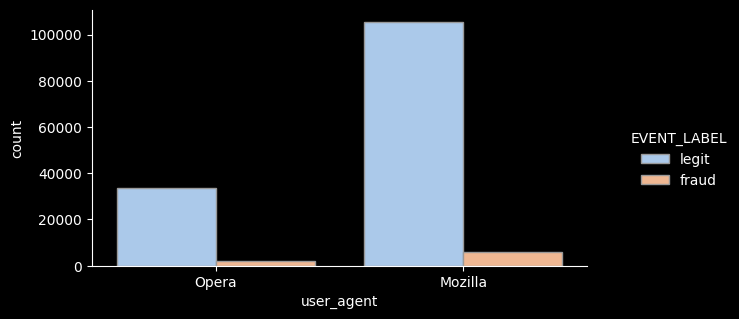

In [27]:
# User agent에 따른 사기거래율 비교
sns.catplot(x='user_agent', hue='EVENT_LABEL',  kind='count', palette='pastel', edgecolor='.6', data=df);
plt.gcf().set_size_inches(8,3)

In [28]:
cat_val = 'user_agent'

# 1단계
df_tran = pd.DataFrame(df.groupby([cat_val, 'EVENT_LABEL'])['EVENT_TIMESTAMP'].count()).reset_index()
df_tran.head(5)

# 2단계
df_pivot = pd.pivot_table(df_tran,                  # 피벗할 데이터프레임
                      index = cat_val,              # 행 위치에 들어갈 열
                      columns = 'EVENT_LABEL',      # 열 위치에 들어갈 열
                      values = 'EVENT_TIMESTAMP')   # 데이터로 사용할 열
# 3단계
df_pivot = df_pivot.reset_index()
df_pivot.columns.names=['']

# 4단계
df_pivot['ratio'] =   round((df_pivot.iloc[:,1] / (df_pivot.iloc[:,1] + df_pivot.iloc[:,2])) * 100,1)
df_pivot

,user_agent,fraud,legit,ratio
0,Mozilla,6121,105492,5.5
1,Opera,1883,33504,5.3


In [29]:
# currency 구성 여부
df['currency'].value_counts()

currency
cad    111543
usd     31151
eur      4306
Name: count, dtype: int64

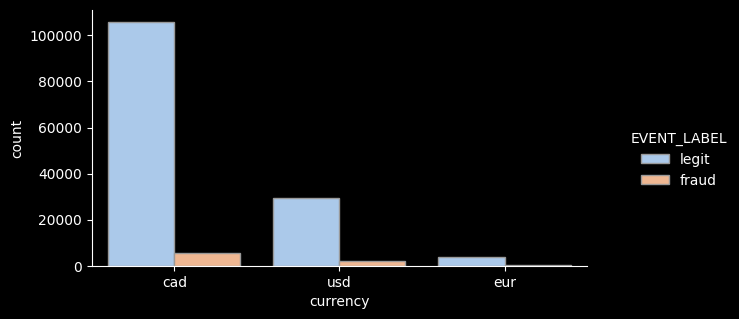

In [30]:
# currency에 따른 사기거래율 비교
sns.catplot(x='currency', hue='EVENT_LABEL',  kind='count', palette='pastel', edgecolor='.6', data=df);
plt.gcf().set_size_inches(8,3)

In [31]:
cat_val = 'currency'

# 1단계
df_tran = pd.DataFrame(df.groupby([cat_val, 'EVENT_LABEL'])['EVENT_TIMESTAMP'].count()).reset_index()
df_tran.head(5)

# 2단계
df_pivot = pd.pivot_table(df_tran,                  # 피벗할 데이터프레임
                      index = cat_val,              # 행 위치에 들어갈 열
                      columns = 'EVENT_LABEL',      # 열 위치에 들어갈 열
                      values = 'EVENT_TIMESTAMP')   # 데이터로 사용할 열
# 3단계
df_pivot = df_pivot.reset_index()
df_pivot.columns.names=['']

# 4단계
df_pivot['ratio'] =   round((df_pivot.iloc[:,1] / (df_pivot.iloc[:,1] + df_pivot.iloc[:,2])) * 100,1)
df_pivot

,currency,fraud,legit,ratio
0,cad,5674,105869,5.1
1,eur,443,3863,10.3
2,usd,1887,29264,6.1


In [32]:
cat_val = 'transaction_type'

# 1단계
df_tran = pd.DataFrame(df.groupby([cat_val, 'EVENT_LABEL'])['EVENT_TIMESTAMP'].count()).reset_index()
df_tran.head(5)

# 2단계
df_pivot = pd.pivot_table(df_tran,                  # 피벗할 데이터프레임
                      index = cat_val,              # 행 위치에 들어갈 열
                      columns = 'EVENT_LABEL',      # 열 위치에 들어갈 열
                      values = 'EVENT_TIMESTAMP')   # 데이터로 사용할 열
# 3단계
df_pivot = df_pivot.reset_index()
df_pivot.columns.names=['']

# 4단계
df_pivot['ratio'] =   round((df_pivot.iloc[:,1] / (df_pivot.iloc[:,1] + df_pivot.iloc[:,2])) * 100,1)
df_pivot

,transaction_type,fraud,legit,ratio
0,A,4.0,9.0,30.8
1,B,84.0,327.0,20.4
2,C,128.0,8338.0,1.5
3,D,567.0,14731.0,3.7
4,E,5.0,587.0,0.8
5,F,1091.0,14289.0,7.1
6,G,763.0,14857.0,4.9
7,H,918.0,9779.0,8.6
8,I,1025.0,14840.0,6.5
9,J,36.0,125.0,22.4


In [33]:
df_pivot.sort_values(by=['ratio'], ascending=False)

,transaction_type,fraud,legit,ratio
0,A,4.0,9.0,30.8
15,P,11.0,36.0,23.4
9,J,36.0,125.0,22.4
1,B,84.0,327.0,20.4
16,Q,142.0,956.0,12.9
13,N,276.0,2130.0,11.5
18,S,729.0,6724.0,9.8
21,V,437.0,4105.0,9.6
20,U,1167.0,12459.0,8.6
7,H,918.0,9779.0,8.6


## Session 3
## ML 활용 사기 거래 예측

### 모델링을 위한 데이터 준비
---
* 모델링을 수행하기 위해 X와 Y로 데이터 나눔  
* 학습과 예측을 위한 Train/Test set 분할


In [34]:
df.head(5)

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,ip_address,user_agent,email_domain,phone_number,billing_city,billing_postal,...,EVENT_TIMESTAMP,applicant_name,billing_address,merchant_id,locale,tranaction_initiate,days_since_last_logon,inital_amount,EVENT_LABEL,transaction_amt_gp
0,3371.0,2167.0,56.0,2572.0,154.68.49.124,Opera,perez-garza.com,878-111-5140,Woodsburgh,96336.0,...,2020-12-29 09:05:51,Linda Wright,4684 Sharon Ranch,066-82-8795,niu_NZ,O,59.0,13646.0,legit,2
1,2714.0,2045.0,48.0,4517.0,39.131.125.85,Opera,mcneil-ortega.com,(002)736-0139,West Kevin,78083.0,...,2021-06-22 18:05:06,Terri Rivera,7642 Allison Ramp,669-99-9459,apn_IN,J,0.0,11930.0,legit,2
2,6987.0,2892.0,61.0,5007.0,166.245.194.83,Mozilla,davis-calderon.com,(983)585-2863x652,Lorichester,83236.0,...,2021-05-10 13:48:38,Sarah Gray,4948 Lisa Passage,086-41-1624,dv_MV,T,83.0,7412.0,legit,2
3,2712.0,3040.0,28.0,6022.0,100.1.217.216,Mozilla,rose-lee.org,+1-678-897-3420x60738,Stephenmouth,78364.0,...,2021-03-11 07:36:40,Valerie Jenkins,1616 Little Camp,669-97-4021,byn_ER,M,24.0,4623.0,legit,3
4,3598.0,2976.0,66.0,2600.0,113.156.65.245,Mozilla,nash.net,(013)204-1766x92641,New Brianmouth,77499.0,...,2021-03-27 06:13:35,Amy Coleman,149 Harris Rapid,088-21-6329,the_NP,K,21.0,1905.0,legit,2


In [35]:
# Train/Test data에는 문자형태로 이루어진 데이터를 Input 할 수 없음
# Model에서 이해할 수 있는 1, 0으로 Target data 변경
import numpy as np
df['EVENT_LABEL']=np.where(df['EVENT_LABEL']=='fraud', 1, 0)
df['EVENT_LABEL'].value_counts()

EVENT_LABEL
0    138996
1      8004
Name: count, dtype: int64

In [36]:
# 모델링을 학습하기 위한 X, Y 구분
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X = df.drop(['EVENT_TIMESTAMP', 'EVENT_LABEL', 'transaction_amt_gp'], axis=1)
Y=df['EVENT_LABEL']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(102900, 24) (44100, 24)
(102900,) (44100,)


In [37]:
# Label encoding 이전 범수형 변수 리스트 확인
print(categorical_list)

['ip_address', 'user_agent', 'email_domain', 'phone_number', 'billing_city', 'billing_state', 'currency', 'cvv', 'signature_image', 'transaction_type', 'transaction_env', 'EVENT_TIMESTAMP', 'applicant_name', 'billing_address', 'merchant_id', 'locale', 'tranaction_initiate', 'EVENT_LABEL']


In [39]:
# 사용하지 않을 카테고리형 변수는 리스트에서 제외
categorical_list.remove('EVENT_LABEL')
categorical_list.remove('EVENT_TIMESTAMP')

In [40]:
print(categorical_list)

['ip_address', 'user_agent', 'email_domain', 'phone_number', 'billing_city', 'billing_state', 'currency', 'cvv', 'signature_image', 'transaction_type', 'transaction_env', 'applicant_name', 'billing_address', 'merchant_id', 'locale', 'tranaction_initiate']


In [41]:
# Categorical 변수는 one-hot 인코딩 or label 인코딩을 통해 숫자형 변수로 변경해야 함
# one-hot 인코딩은 차원이 많은 변수에 불리, label 인코딩은 회귀관련 알고리즘에서 사용 어려움.
from sklearn.preprocessing import LabelEncoder

for col in categorical_list:
    print(col)
    le = LabelEncoder()
    le.fit(list(x_train[col].values)+ list(x_test[col].values))
    x_train[col] = le.transform(x_train[col])
    x_test[col]=le.transform(x_test[col])

ip_address
user_agent
email_domain
phone_number
billing_city
billing_state
currency
cvv
signature_image
transaction_type
transaction_env
applicant_name
billing_address
merchant_id
locale
tranaction_initiate


In [42]:
x_train[categorical_list].head(3)

,ip_address,user_agent,email_domain,phone_number,billing_city,billing_state,currency,cvv,signature_image,transaction_type,transaction_env,applicant_name,billing_address,merchant_id,locale,tranaction_initiate
54583,290,0,1908,9640,315,22,0,20,5,7,5,95595,89692,84649,200,5
46048,8351,0,4364,3039,2819,4,0,14,2,16,5,49527,124720,126531,68,1
44638,7432,0,3768,8812,5884,35,0,3,18,23,23,3546,11957,103986,206,7


In [43]:
x_test[categorical_list].head(3)

,ip_address,user_agent,email_domain,phone_number,billing_city,billing_state,currency,cvv,signature_image,transaction_type,transaction_env,applicant_name,billing_address,merchant_id,locale,tranaction_initiate
69840,2672,0,1766,10611,7986,42,0,20,6,5,2,23998,6948,146758,53,20
52757,9243,0,4038,9279,760,42,2,23,20,23,3,66632,75125,6159,141,10
54510,6059,0,6693,7462,1302,17,2,3,20,23,23,84918,61795,45379,97,7


### 모델 학습 및 평가
---
* 모델을 학습하고 예측을 수행하여 성능을 평가

In [44]:
# 학습
from sklearn.metrics import classification_report
rfc = RandomForestClassifier(random_state = 123456, max_depth=8, n_estimators=500)
rfc.fit(x_train, y_train)

# 예측
y_pred_train = rfc.predict(x_train)
y_pred_test = rfc.predict(x_test)


print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     97297
           1       0.97      0.34      0.50      5603

    accuracy                           0.96    102900
   macro avg       0.97      0.67      0.74    102900
weighted avg       0.96      0.96      0.95    102900

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     41699
           1       0.96      0.32      0.48      2401

    accuracy                           0.96     44100
   macro avg       0.96      0.66      0.73     44100
weighted avg       0.96      0.96      0.95     44100



In [45]:
pd.Series(y_pred_test).value_counts()

0    43301
1      799
Name: count, dtype: int64

In [46]:
# ROC 개념
# 이진 분류기의 성능을 평가할 때 사용하는 지표, 100에 가까울수록 모델 성능이 좋음.
# 과적합 문제, Train, test set에 성능을 최대한 줄여주는 것이 과적합 방지
from sklearn.metrics import roc_auc_score

y_pred_train_proba = rfc.predict_proba(x_train)[:, 1]
y_pred_test_proba = rfc.predict_proba(x_test)[:, 1]

roc_score_train = roc_auc_score(y_train, y_pred_train_proba)
roc_score_test = roc_auc_score(y_test, y_pred_test_proba)

print("roc_score_train :",roc_score_train)
print("roc_score_test :",roc_score_test)

roc_score_train : 0.9495805552332263
roc_score_test : 0.9269088170503471


### 중요변수 파악
---

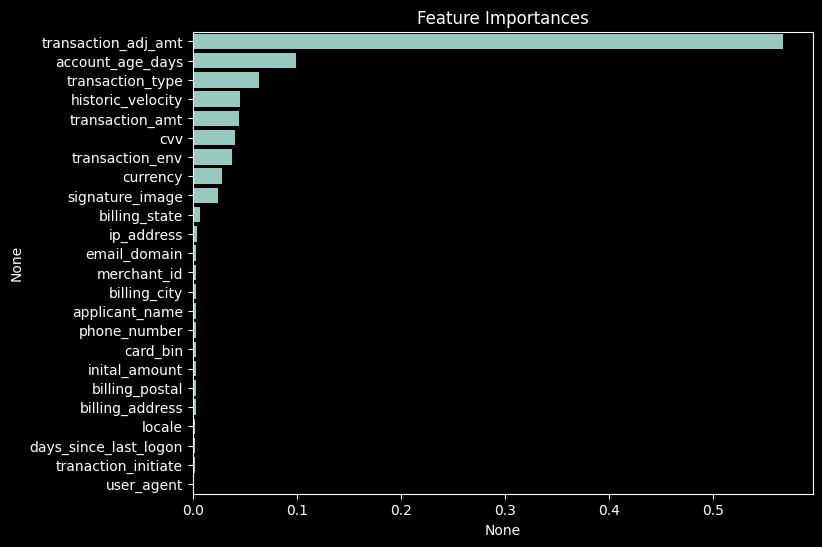

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

ftr_importances_values = rfc.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = x_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:30]

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
# plt.rc('xtick', labelsize=5)
plt.show()

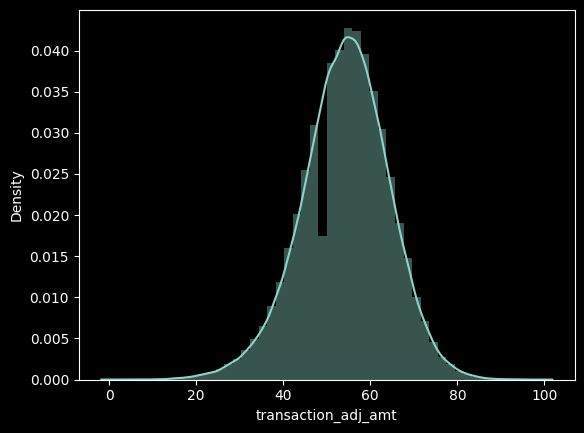

In [49]:
# 중요변수 1번에 대한 상세 탐색
sns.distplot(df['transaction_adj_amt']);

In [50]:
# 구간화
import numpy as np
df['transaction_adj_amt_gp'] = np.where(df['transaction_adj_amt']<=40, 1,
                                        np.where(df['transaction_adj_amt']<=60, 2, 3))
df[['transaction_adj_amt', 'transaction_adj_amt_gp']]

,transaction_adj_amt,transaction_adj_amt_gp
0,56.0,2
1,48.0,2
2,61.0,3
3,28.0,1
4,66.0,3
...,...,...
149995,57.0,2
149996,61.0,3
149997,48.0,2
149998,59.0,2


In [51]:
df.groupby(['transaction_adj_amt_gp', 'EVENT_LABEL'])['EVENT_TIMESTAMP'].count()

transaction_adj_amt_gp  EVENT_LABEL
1                       0               8072
                        1               4628
2                       0              92394
                        1               3131
3                       0              38530
                        1                245
Name: EVENT_TIMESTAMP, dtype: int64

In [52]:
# 조정된 금액이 작을수록 사기거래 확률이 급격시 상승한다. (※ Critical한 변수).
print("gp1 :", (4628 / (4628+8072)) * 100)
print("gp2 :", (3131 / (3131+92394)) * 100)
print("gp3 :", (245 / (245+38530)) * 100)

gp1 : 36.44094488188976
gp2 : 3.277676001046846
gp3 : 0.6318504190844616



### 모델 Save and Read
---
* 최종 모델을 저장 및 다시 불러오기

In [53]:
import pickle
# 모델 저장
saved_model = pickle.dumps(rfc)

# 모델 Read
clf_from_pickle = pickle.loads(saved_model)